# Merton Jump-Diffusion Model Example

This notebook demonstrates how to calibrate and use the Merton jump-diffusion model for financial modeling.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import norm, poisson

# Import the MarketModel class
import sys
sys.path.append('..')  # Add parent directory to path
from src.utils.financial_utils import calibrate_merton_model

## Load Historical Data

Load historical price data for a CAC40 stock.

In [2]:
# Read the file with tab separator
df = pd.read_csv("../Data/CAC40 daily 10y/AIRBUS_2025-03-08_Data_1d_10y.txt", sep='\t')

# Convert first column to datetime and set as index
df.index = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M')
df = df.drop('date', axis=1)  # Remove the original date column

# Display the first few rows
df.head()

,ouv,haut,bas,clot,vol,devise,Unnamed: 7
date,,,,,,,
2015-03-09,58.97,59.49,58.42,58.88,1917367,EUR,NaN
2015-03-10,58.58,59.16,57.92,58.88,3101036,EUR,NaN
2015-03-11,59.10,61.53,59.04,61.43,3256951,EUR,NaN
2015-03-12,61.50,62.48,61.40,62.08,3119145,EUR,NaN
2015-03-13,62.12,63.56,61.85,63.56,3358370,EUR,NaN


## Visualize Historical Prices

Plot the historical closing prices.

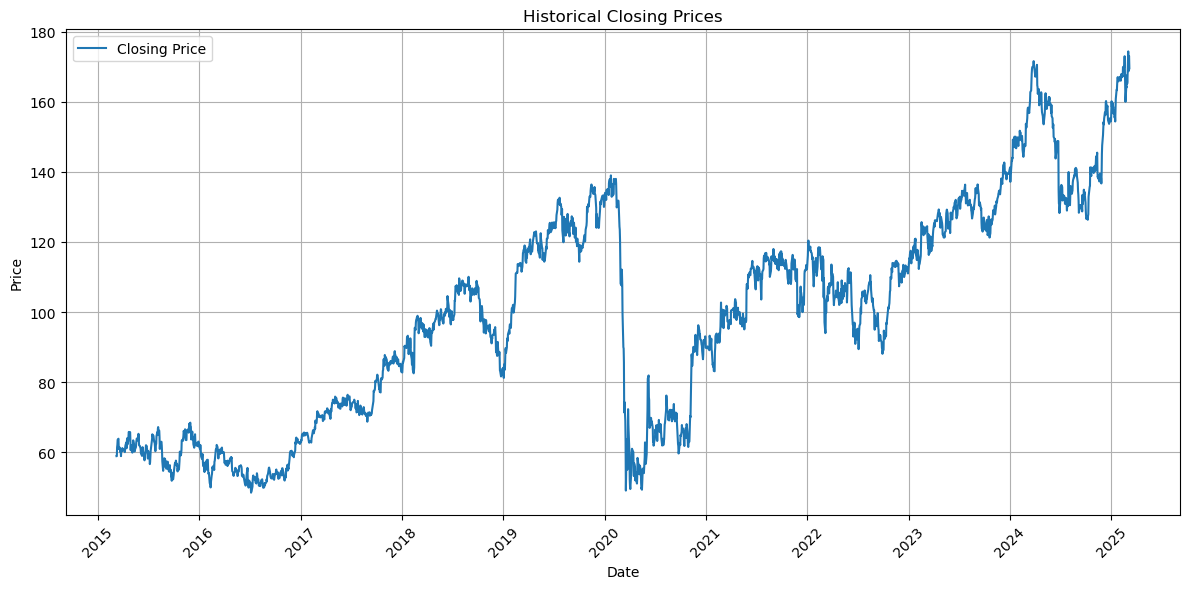

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['clot'], label='Closing Price')
plt.title('Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Calculate Returns

Calculate log returns from historical prices.

In [4]:
# Extract closing prices
prices = np.array(df["clot"])

# Calculate log returns
returns = np.log(prices[1:] / prices[:-1])

# Display summary statistics
print("Log Returns Summary Statistics:")
print(f"Mean: {np.mean(returns):.6f}")
print(f"Standard Deviation: {np.std(returns):.6f}")
print(f"Skewness: {((returns - np.mean(returns))**3).mean() / np.std(returns)**3:.6f}")
print(f"Kurtosis: {((returns - np.mean(returns))**4).mean() / np.std(returns)**4:.6f}")

Log Returns Summary Statistics:
Mean: 0.000413
Standard Deviation: 0.022002
Skewness: -0.462460
Kurtosis: 19.725708


## Calibrate Merton Model

Calibrate the Merton jump-diffusion model using maximum likelihood estimation.

In [5]:
# Calibrate the Merton model
dt = 1/252  # Daily time step (assuming 252 trading days per year)
merton_params = calibrate_merton_model(returns, dt)

# Extract parameters
mu, sigma, lambda_, mu_J, sigma_J = merton_params

# Display calibrated parameters
print("Calibrated Merton Model Parameters:")
print(f"Drift (μ): {mu:.4f}")
print(f"Volatility (σ): {sigma:.4f}")
print(f"Jump Intensity (λ): {lambda_:.4f}")
print(f"Jump Mean (μ_J): {mu_J:.4f}")
print(f"Jump Volatility (σ_J): {sigma_J:.4f}")

Calibrated Merton Model Parameters:
Drift (μ): 0.1255
Volatility (σ): 0.2412
Jump Intensity (λ): 25.2752
Jump Mean (μ_J): -0.0009
Jump Volatility (σ_J): 0.0528


## Visualize Returns Distribution

Plot the histogram of returns and the fitted Merton model distribution.

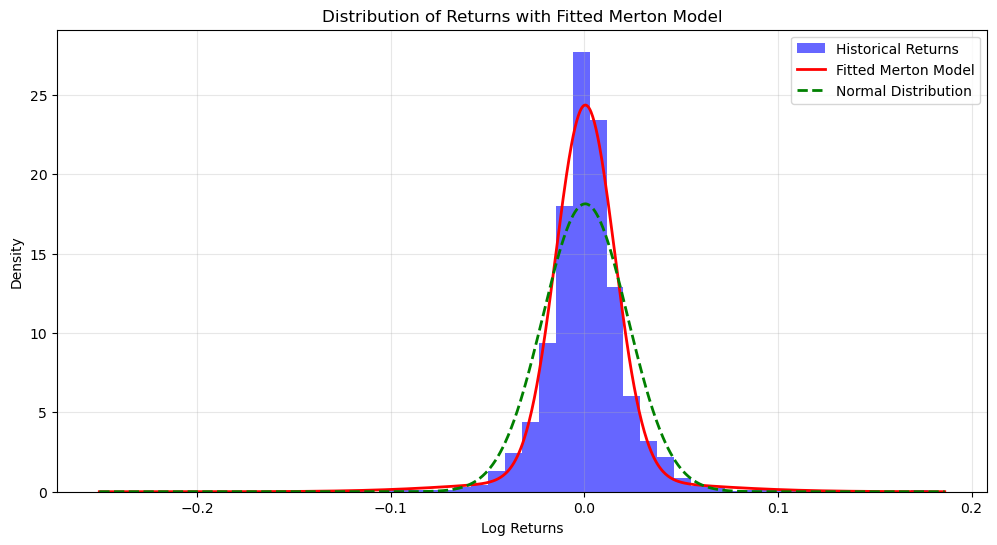

In [6]:
plt.figure(figsize=(12, 6))

# Plot histogram of returns
n, bins, patches = plt.hist(returns, bins=50, density=True, alpha=0.6, color='b', label='Historical Returns')

# Generate x values for plotting
x = np.linspace(min(returns), max(returns), 1000)

# Calculate PDF for Merton model
pdf = (1 - lambda_ * dt) * norm.pdf(x, mu * dt, sigma * np.sqrt(dt)) + \
      (lambda_ * dt) * norm.pdf(x, mu * dt + mu_J, np.sqrt(sigma**2 * dt + sigma_J**2))

plt.plot(x, pdf, 'r-', linewidth=2, label='Fitted Merton Model')

# For comparison, plot normal distribution with same mean and variance
normal_pdf = norm.pdf(x, np.mean(returns), np.std(returns))
plt.plot(x, normal_pdf, 'g--', linewidth=2, label='Normal Distribution')

plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Distribution of Returns with Fitted Merton Model')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Simulate Price Paths

Simulate price paths using the calibrated Merton model.

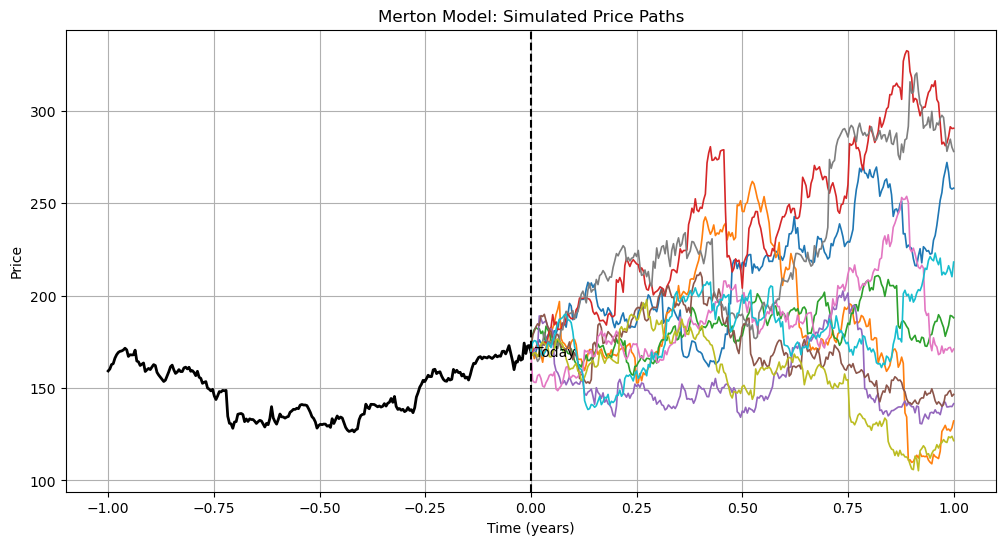

In [7]:
# Simulation parameters
S0 = prices[-1]      # Initial price (last observed price)
T = 1.0              # Time horizon (1 year)
N = 252              # Number of time steps (trading days)
M = 10               # Number of simulated paths

dt = T / N           # Time step
t = np.linspace(0, T, N+1)

# Simulation of price paths
S = np.zeros((M, N+1))
S[:, 0] = S0

for m in range(M):
    W = np.random.normal(0, np.sqrt(dt), N)  # Brownian motion increments
    N_t = np.random.poisson(lambda_ * dt, N) # Poisson process (number of jumps)
    J_t = np.random.normal(mu_J, sigma_J, N) * N_t  # Jump sizes
    
    for i in range(1, N+1):
        dS = mu * S[m, i-1] * dt + sigma * S[m, i-1] * W[i-1] + S[m, i-1] * J_t[i-1]
        S[m, i] = S[m, i-1] + dS

# Plot simulated price paths
plt.figure(figsize=(12, 6))

# Add historical prices for context (last year)
historical_days = min(252, len(prices))
historical_t = np.linspace(-1, 0, historical_days)
plt.plot(historical_t, prices[-historical_days:], 'k-', linewidth=2, label='Historical')

# Plot simulated paths
for m in range(M):
    plt.plot(t, S[m, :], linewidth=1.2)

plt.axvline(x=0, color='k', linestyle='--')
plt.text(0.01, S0, 'Today', verticalalignment='center')

plt.xlabel('Time (years)')
plt.ylabel('Price')
plt.title('Merton Model: Simulated Price Paths')
plt.grid(True)
plt.show()

## Calculate Risk Metrics

Calculate Value-at-Risk (VaR) and Expected Shortfall (ES) from the simulated paths.

Value-at-Risk (VaR) at 95.0% confidence level: 0.4437 or 44.37%
Expected Shortfall (ES) at 95.0% confidence level: 0.5252 or 52.52%


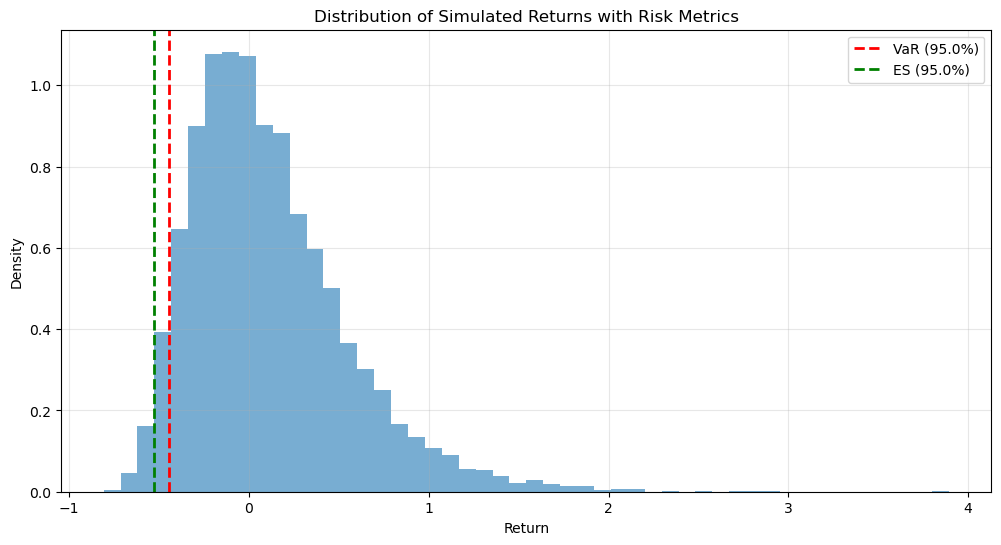

In [8]:
# Increase number of simulations for better risk metrics
M_risk = 10000
S_final = np.zeros(M_risk)

# Simulate terminal values only
for m in range(M_risk):
    S_path = S0
    for i in range(N):
        W = np.random.normal(0, np.sqrt(dt))
        N_t = np.random.poisson(lambda_ * dt)
        J_t = np.random.normal(mu_J, sigma_J) * N_t if N_t > 0 else 0
        dS = mu * S_path * dt + sigma * S_path * W + S_path * J_t
        S_path += dS
    S_final[m] = S_path

# Calculate returns
returns_final = (S_final - S0) / S0

# Calculate risk metrics
alpha = 0.95  # Confidence level
VaR = -np.percentile(returns_final, 100 * (1 - alpha))
ES = -np.mean(returns_final[returns_final <= -VaR])

print(f"Value-at-Risk (VaR) at {alpha*100}% confidence level: {VaR:.4f} or {VaR*100:.2f}%")
print(f"Expected Shortfall (ES) at {alpha*100}% confidence level: {ES:.4f} or {ES*100:.2f}%")

# Plot histogram of simulated returns
plt.figure(figsize=(12, 6))
plt.hist(returns_final, bins=50, density=True, alpha=0.6)
plt.axvline(-VaR, color='r', linestyle='--', linewidth=2, label=f'VaR ({alpha*100}%)')
plt.axvline(-ES, color='g', linestyle='--', linewidth=2, label=f'ES ({alpha*100}%)')
plt.xlabel('Return')
plt.ylabel('Density')
plt.title('Distribution of Simulated Returns with Risk Metrics')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()